In [73]:
#import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score

In [74]:
#read data
df = pd.read_csv("AEP_hourly.csv")
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [75]:
#check N/A data
df.isna().sum()

Datetime    0
AEP_MW      0
dtype: int64

In [76]:
#check null data
df.isnull().sum()

Datetime    0
AEP_MW      0
dtype: int64

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


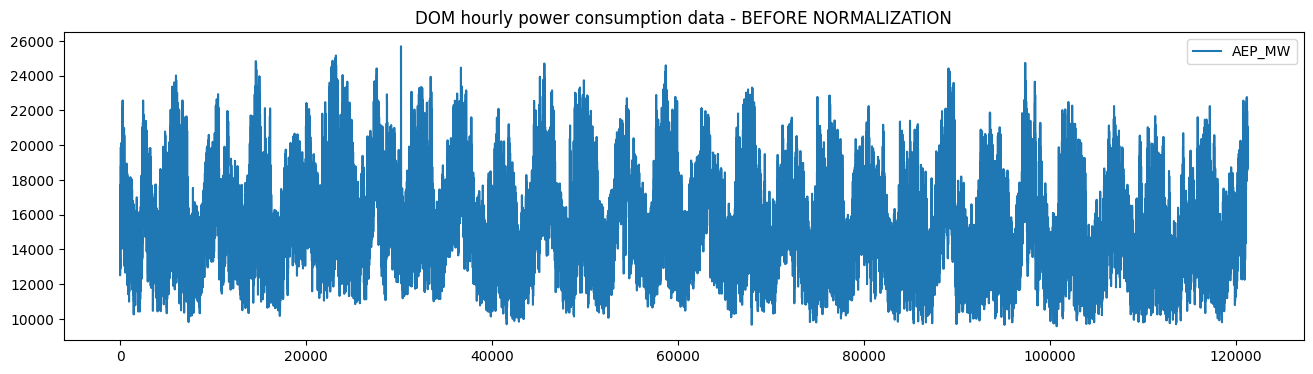

In [78]:
#show data visual before normalization
df.plot(figsize=(16,4), legend =True)
plt.title('DOM hourly power consumption data - BEFORE NORMALIZATION')
plt.show()

In [79]:
def normalize_data(df) :
  scaler = sklearn.preprocessing.MinMaxScaler()
  df['AEP_MW'] = scaler.fit_transform(df['AEP_MW'].values.reshape(-1,1))
  return df

df_norm = normalize_data(df)
df_norm.shape

(121273, 2)

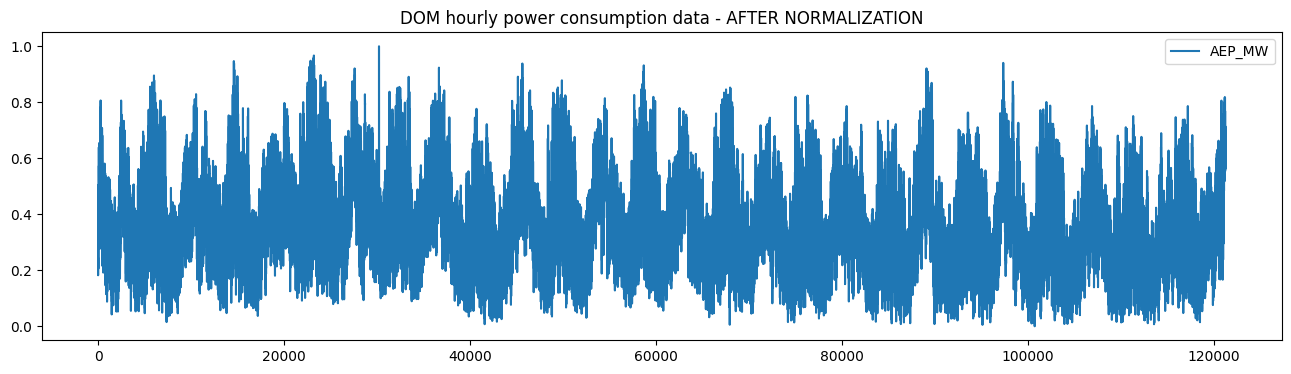

In [80]:
#show data visual after normalization
df_norm.plot(figsize=(16,4), legend =True)
plt.title('DOM hourly power consumption data - AFTER NORMALIZATION')
plt.show()

In [81]:
df_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [82]:
date = df_norm["Datetime"].values
energy_consumption = df_norm["AEP_MW"].values

In [83]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [84]:
#Split data into training and validation
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_train = train_test_split(energy_consumption, date, test_size=0.2, random_state = 0, shuffle=False)

In [85]:
#Show splitted dataset size
print(X_train.shape)
print(X_test.shape)

(97018,)
(24255,)


In [86]:
from keras.layers import Dense, LSTM

data_x_train = windowed_dataset(X_train, window_size=60, batch_size=100, shuffle_buffer=5000)
data_x_test = windowed_dataset(X_test, window_size=60, batch_size=100, shuffle_buffer=5000)

In [87]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                    strides=1, padding="causal",
                    activation="relu",
                    input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, activation="tanh", return_sequences=True),
  tf.keras.layers.LSTM(64, activation="tanh", return_sequences=True),
  tf.keras.layers.LSTM(64, activation="tanh", return_sequences=False),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss="MSE",
              optimizer=optimizer,
              metrics=["mae"])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 32)          192       
                                                                 
 lstm_12 (LSTM)              (None, None, 64)          24832     
                                                                 
 lstm_13 (LSTM)              (None, None, 64)          33024     
                                                                 
 lstm_14 (LSTM)              (None, 64)                33024     
                                                                 
 dense_12 (Dense)            (None, 30)                1950      
                                                                 
 dense_13 (Dense)            (None, 10)                310       
                                                                 
 dense_14 (Dense)            (None, 1)                

In [88]:
max = df_norm['AEP_MW'].max()
max

0.9999999999999999

In [89]:
min = df_norm['AEP_MW'].min()
min

0.0

In [90]:
threshold = (max - min) * 0.1
threshold

0.09999999999999999

In [91]:
history = model.fit(data_x_train, epochs = 10, validation_data=data_x_test)

Epoch 1/10
970/970 [==============================] - 47s 41ms/step - loss: 0.0124 - mae: 0.0831 - val_loss: 0.0053 - val_mae: 0.0567
Epoch 2/10
970/970 [==============================] - 37s 38ms/step - loss: 0.0051 - mae: 0.0564 - val_loss: 0.0042 - val_mae: 0.0501
Epoch 3/10
970/970 [==============================] - 36s 36ms/step - loss: 0.0037 - mae: 0.0468 - val_loss: 0.0026 - val_mae: 0.0392
Epoch 4/10
970/970 [==============================] - 38s 38ms/step - loss: 0.0017 - mae: 0.0306 - val_loss: 0.0012 - val_mae: 0.0261
Epoch 5/10
970/970 [==============================] - 42s 43ms/step - loss: 0.0011 - mae: 0.0240 - val_loss: 8.8570e-04 - val_mae: 0.0213
Epoch 6/10
970/970 [==============================] - 36s 36ms/step - loss: 9.1059e-04 - mae: 0.0220 - val_loss: 7.7564e-04 - val_mae: 0.0197
Epoch 7/10
970/970 [==============================] - 44s 45ms/step - loss: 7.9831e-04 - mae: 0.0204 - val_loss: 6.8167e-04 - val_mae: 0.0178
Epoch 8/10
970/970 [======================